In [50]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import AnaUtils as au
import os,glob

In [102]:
def DRun(fname,nbase=50,winS=5,winF=5,cut=4,pmt=0,binw=0.5,ret=False):
    waves = au.ReadDDC10_BinWave(fname)
    waves[0],base = au.Subtract_Baseline(waves[0],nBase=nbase)
    #require baseline has no pulse. i.e. integral over baseline less than cut*rms
    bmask = np.absolute(integrate.simps(waves[0][:,pmt,:nbase]))<cut*integrate.simps(np.ones(nbase))*base[1][:,pmt]
    sumWave = waves[0][:,pmt,:].sum(axis=0)/float(waves[1]['numEvents'])
    PromptPeak = np.argmax(sumWave)
    plt.clf()
    plt.plot(sumWave,marker='x')
    plt.show()
    Qhist = au.winQHist(waves,ch=pmt,init=PromptPeak-winS,end=PromptPeak+winF,binW=binw,hrange=[-3,10],evMask=bmask[...,np.newaxis])
    if ret:
        Qhist['waves'] = waves[0][:,pmt]
        Qhist['evMask'] = bmask
        Qhist['baserms'] = base[0][:,pmt]
        return Qhist,waves[1]
    else:
        return Qhist['qHist']
    
def plotQ(qhist,sdir,xbase = 1.0):
    plt.clf()
    
    ax = plt.errorbar(qhist[1],qhist[0],marker='+',yerr=np.sqrt(qhist[2]))
    plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(xbase))
    plt.xlabel('Q [pC]')
    plt.ylabel('dRate/dQ [Hz/pC]')
    plt.savefig(sdir+"/dQHist.png")
    plt.show()
from scipy.optimize import curve_fit

def fitQ(Qhist,P,bounds=(-np.inf,np.inf),doErr=False):
    def gauss(x, x0, y0, sigma):
        p = [x0, y0, sigma]
        return p[1]* np.exp(-((x-p[0])/p[2])**2)
    def gauss2(x,x0,y0,s0,x1,y1,s1):
        p0 = gauss(x,x0,y0,s0)
        p1 = gauss(x,x1,y1,s1)
        return p0+p1
    def gauss3(x,x0,y0,s0,x1,y1,s1,x2,y2,s2):
        p0 = gauss(x,x0,y0,s0)
        p1 = gauss(x,x1,y1,s1)
        g2 = 2*x1 - x0 +x2
        p2 = gauss(x,g2,y2,s2)
        return p0+p1+p2
    ng = len(P)/3
    mx = Qhist[1]
    my = Qhist[0]
    merr = None
    abSig = None
    if doErr:
        args = Qhist[3]
        mx = mx[args]
        my = my[args]
        merr = np.sqrt(Qhist[2][args])
        abSig = True
    if ng==3:
        fit,tmp = curve_fit(gauss3,mx,my,p0=P,bounds=bounds,sigma=merr,absolute_sigma=abSig,maxfev=50000,ftol=1e-7,gtol=1e-7)
    elif ng==2:
        fit,tmp = curve_fit(gauss2,mx,my,p0=P,bounds=bounds,sigma=merr,absolute_sigma=abSig,maxfev=50000,ftol=1e-7,gtol=1e-7)
    elif ng==1:
        fit,tmp = curve_fit(gauss,mx,my,p0=P,bounds=bounds,sigma=merr,absolute_sigma=abSig,maxfev=50000,ftol=1e-7,gtol=1e-7)
    else:
        print('No valid fit function found')
        return None
    return fit,tmp

In [103]:
wDir = '/data/share/KA0206'
fWaves = [os.path.splitext(iF)[0] for iF in glob.glob(wDir+'/DR/*.bin')]
fWaves.sort()
fWaves,

(['/data/share/KA0206/DR/1500V2_200817_250_samples_100000_events',
  '/data/share/KA0206/DR/1500V3_200817_250_samples_100000_events',
  '/data/share/KA0206/DR/1500V_200817_250_samples_100000_events'],)

In [104]:
def fullRun(fname,sdir,fit=False):
    bW = 0.05
    Qhist = DRun(fname,30,3,5,5,0,bW,False)
    plotQ(Qhist,sdir+'/DR')
    if fit:
        popt,pcov = fitQ(Qhist,[0,10,0.5,1.8,1,1])
        QNoise = min([popt[0],popt[3]])
        QSPE = max([popt[0],popt[3]])
        Qbin0 = np.argmax(Qhist[1]>QNoise)
        Qbin1 = np.argmax(Qhist[1]>QSPE)
        print(popt)
    else:
        Qbin0 = np.argmax(Qhist[1]>0)
        Qbin1 = np.argmax(Qhist[1]>1.6)
        
    Qvalley = Qbin0 + np.argmin(Qhist[0][Qbin0:Qbin1])
    eDR = np.sum(Qhist[0][Qvalley:])
    eDRErr = np.sqrt(np.sum(Qhist[2][Qvalley:]))
    DR = eDR*bW
    DRErr = DR*eDRErr/eDR
    print([fname,Qhist[1][Qvalley],eDR,(DR,DRErr)])
    

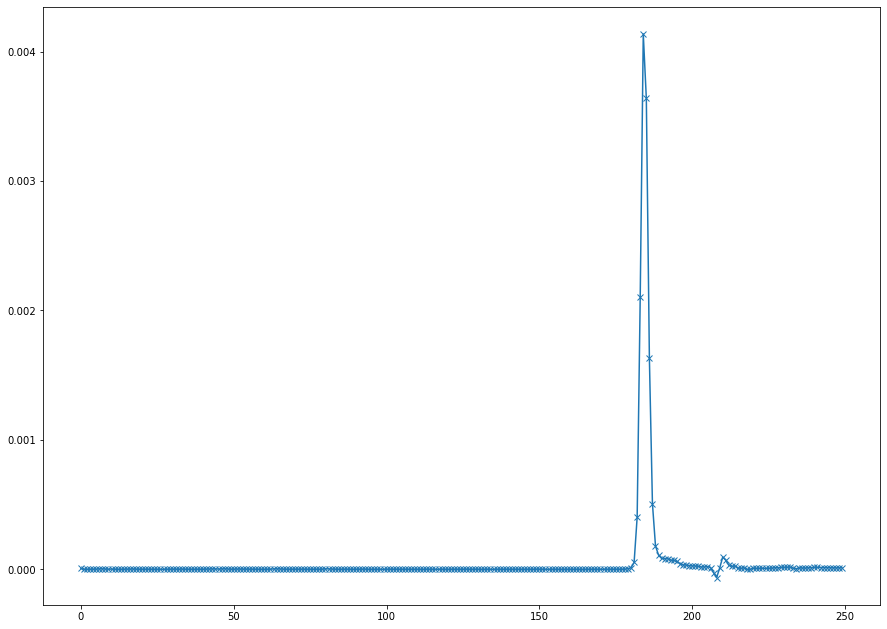

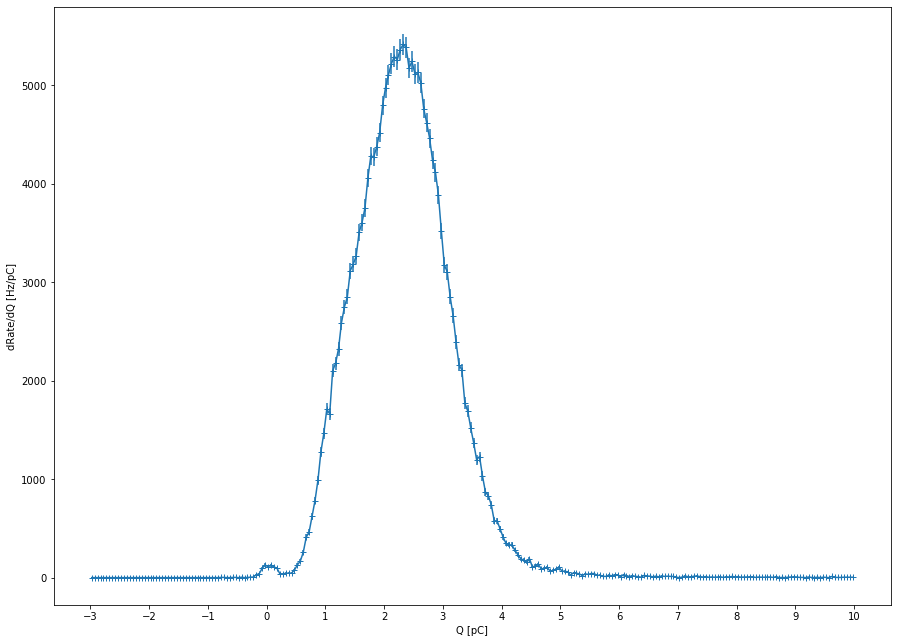

['/data/share/KA0206/DR/1500V2_200817_250_samples_100000_events', 0.27500000000000013, 206362.1974457456, (10318.109872287281, 32.735950498217775)]


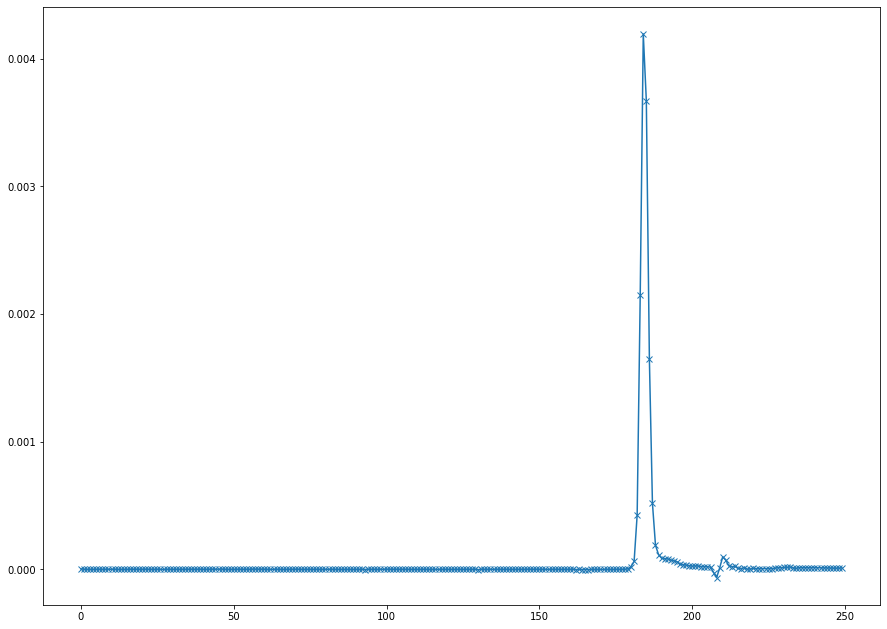

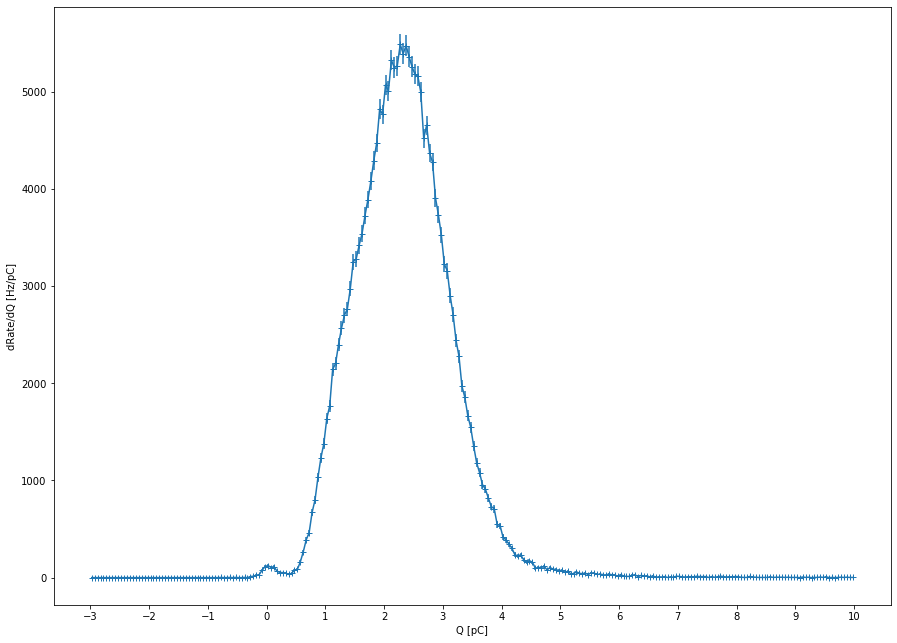

['/data/share/KA0206/DR/1500V3_200817_250_samples_100000_events', 0.3750000000000002, 206106.64272659976, (10305.33213632999, 32.70660633492782)]


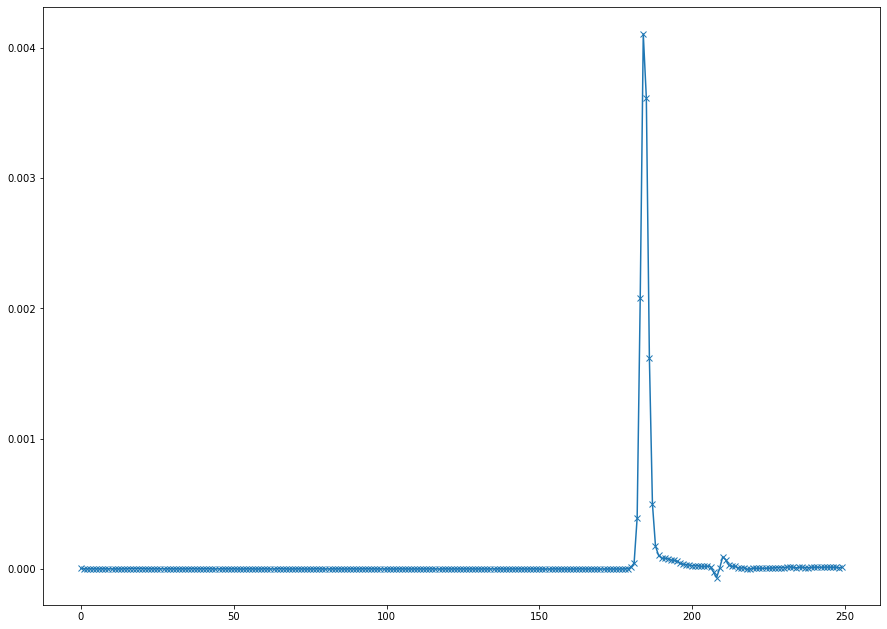

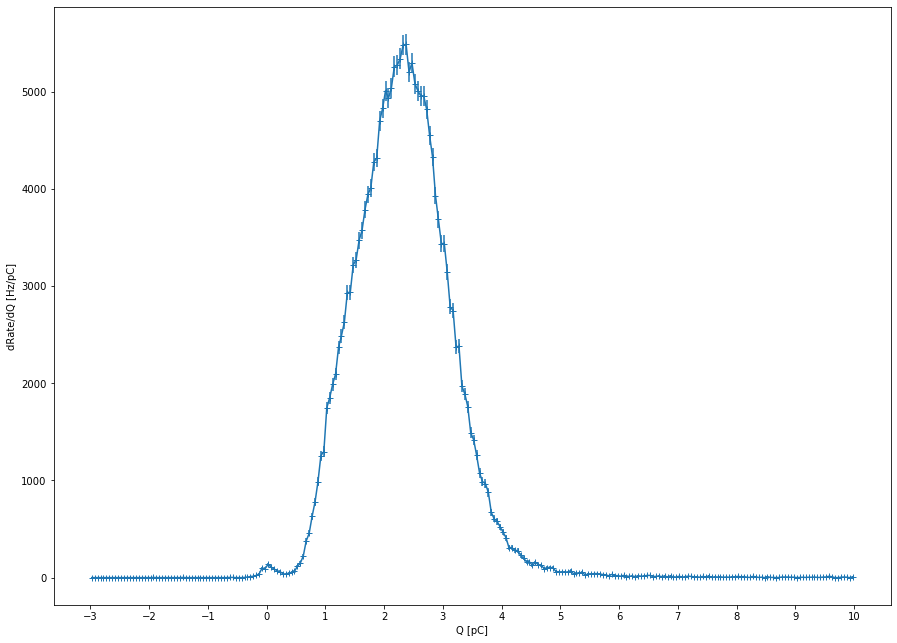

['/data/share/KA0206/DR/1500V_200817_250_samples_100000_events', 0.3250000000000002, 206213.83806024434, (10310.691903012217, 32.710275640194006)]


[None, None, None]

In [105]:
[fullRun(fWave,wDir,False) for fWave in fWaves]